In [2]:
#!pip install --upgrade opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 19.7 MB/s eta 0:00:0000:0100:01


In [2]:
#import all libraries

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil
import random
import matplotlib.image as mpimg

2023-06-15 22:35:14.603218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


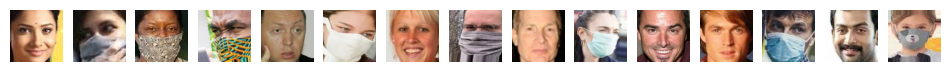

In [3]:
# Specify the directory containing the input images
input_dir = 'Data/all_images'

# Get the list of image files in the input directory
image_files = os.listdir(input_dir)

# Specify the number of random images to display
num_images = 15

# Randomly select image files from the list
random_images = random.sample(image_files, num_images)

# Create subplots for displaying the images
fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

# Iterate over the selected images and plot them
for i, image_file in enumerate(random_images):
    # Construct the path to the image file
    image_path = os.path.join(input_dir, image_file)
    
    # Read the image using mpimg
    image = mpimg.imread(image_path)
    
    # Display the image in the corresponding subplot
    axes[i].imshow(image)
    
    # Remove the axis labels
    axes[i].axis('off')

# Display the subplots containing the random images
plt.show()

In [4]:
# Specify the input directory where the images are located
input_dir = 'Data/all_images'

# Construct the glob pattern to match PNG files in the input directory
glob_dir = input_dir + '/*.png'

# Retrieve the paths of all PNG files in the input directory using glob, limiting to the first 1000 images
image_paths = glob.glob(glob_dir)[:1000]

# Initialize an empty list to store the images
images = []

# Iterate over the image paths
for path in image_paths:
    # Read the image using cv2
    img = cv2.imread(path)
    
    # Resize the image to a specified size (e.g., 224x224)
    img_resized = cv2.resize(img, (224, 224))
    
    # Append the resized image to the list of images
    images.append(img_resized)

# Convert the list of images to a NumPy array and change the data type to float32
images = np.array(images, dtype=np.float32)

# Normalize the pixel values of the images by dividing by 255.0 to ensure they fall within the range of [0, 1]
images = images / 255.0

In [5]:
# Load the pre-trained MobileNetV2 model without the top (fully connected) layers
model = tf.keras.applications.MobileNetV2(
    include_top=False,  # Exclude the top layers
    weights='imagenet',  # Use pre-trained weights from ImageNet
    input_shape=(224, 224, 3)  # Specify the input shape of the images
)

# Preprocess the images and make predictions using the model
predictions = model.predict(images.reshape(-1, 224, 224, 3))

# Reshape the predictions to match the shape of the original images
pred_images = predictions.reshape(images.shape[0], -1)

2023-06-15 22:36:07.790929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


32/32 [==============================] - 9s 251ms/step


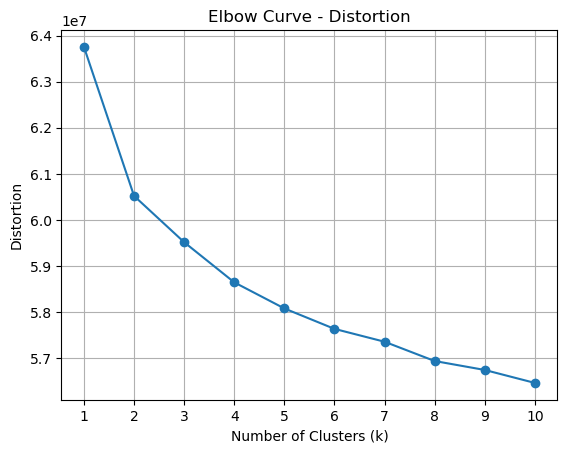

In [6]:
# Initialize empty lists to store distortion values and corresponding cluster numbers
elbow_distortions = []
kl = []
kmax = 10

# Perform K-means clustering for different values of k
for k in range(1, kmax + 1):
    kmeans = KMeans(n_clusters=k).fit(pred_images)  # Perform K-means clustering
    distortions = kmeans.inertia_  # Get the distortion (sum of squared distances)
    elbow_distortions.append(distortions)  # Append the distortion value to the list
    kl.append(k)  # Append the value of k to the list

# Plotting the elbow curve
plt.plot(kl, elbow_distortions, marker='o')  # Plot the distortion values against the number of clusters
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Curve - Distortion')
plt.xticks(kl)  # Set the x-axis tick values to be the values of k
plt.grid(True)  # Add a grid to the plot
plt.show()  # Display the plot

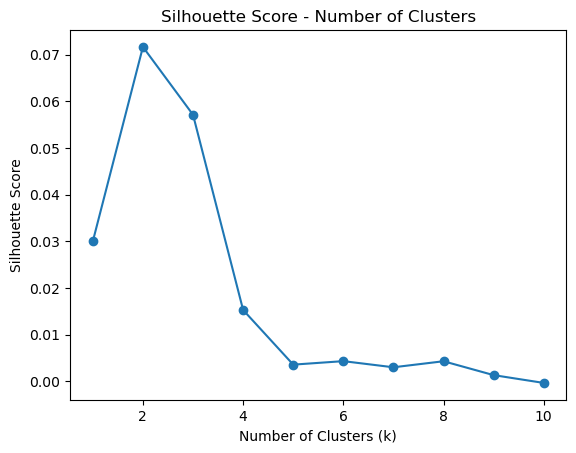

In [15]:
sil = []  # Initialize an empty list to store silhouette scores
kl = []  # Initialize an empty list to store values of k
kmax = 10  # Maximum value of k

# Perform K-means clustering for different values of k
for k in range(1, kmax+1):
    kmeans2 = KMeans(n_clusters=k).fit(pred_images)  # Perform K-means clustering
    labels = kmeans2.labels_  # Get the cluster labels
    if k == 1:
        sil_score = 0.03  # Assign a default silhouette score of 0 for k=1
    else:
        sil_score = silhouette_score(pred_images, labels, metric='euclidean')  # Calculate the silhouette score
    sil.append(sil_score)  # Append the silhouette score to the list
    kl.append(k)  # Append the value of k to the list

# Plotting the silhouette scores
plt.plot(kl, sil, marker='o')  # Plot the silhouette scores against the number of clusters (k)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score - Number of Clusters')
plt.show()  # Display the plot

In [20]:
k = 2  # Number of clusters
kmodel = KMeans(n_clusters=k, random_state=728)  # Create a K-means clustering model with the specified number of clusters
kmodel.fit(pred_images)  # Fit the model to the preprocessed images
kpredictions = kmodel.predict(pred_images)  # Perform clustering and obtain the cluster assignments for each image

In [21]:
paths = [file for file in glob.glob(glob_dir)[:1000]]  # Get a list of file paths for the first 1000 files that match the glob pattern

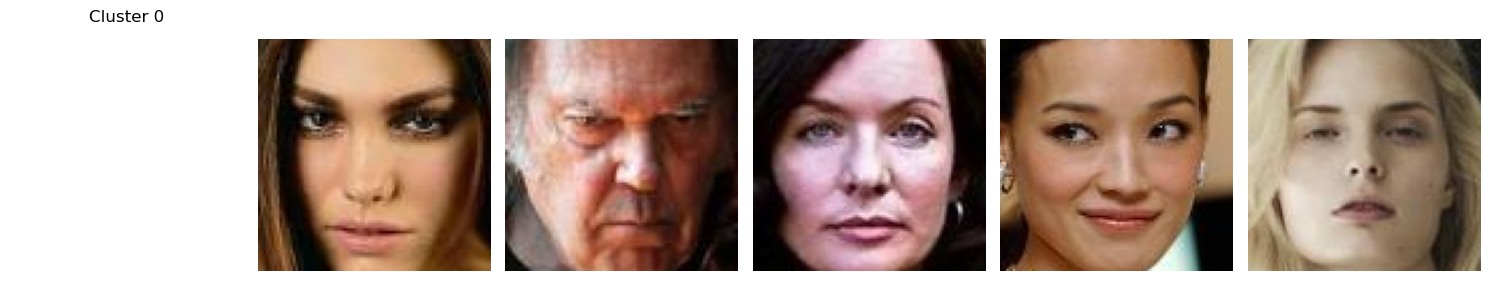

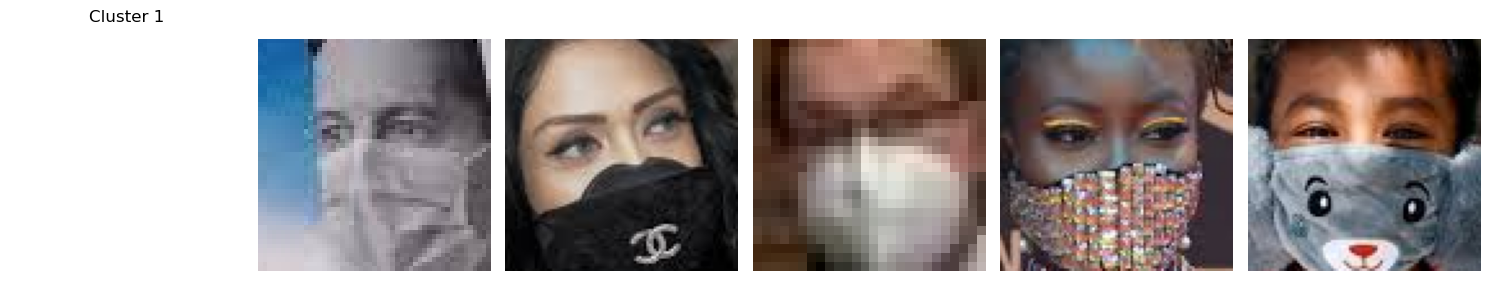

In [28]:
# Remove existing output directory
shutil.rmtree('Data/output')

# Create directories for each cluster
for i in range(k):
    os.makedirs("Data/output/cluster" + str(i))

# Copy images to respective cluster directories
for i in range(len(paths)):
    shutil.copy2(paths[i], "Data/output/cluster" + str(kpredictions[i]))

# Plot 5 random images from each cluster
num_images_per_cluster = 5

for i in range(k):
    cluster_dir = "Data/output/cluster" + str(i)
    image_files = os.listdir(cluster_dir)
    random_images = random.sample(image_files, min(num_images_per_cluster, len(image_files)))

    fig, axs = plt.subplots(1, num_images_per_cluster + 1, figsize=(15, 3))
    
    # Plot cluster name on the left
    axs[0].set_title("Cluster " + str(i))
    axs[0].axis('off')
    
    for j, image_file in enumerate(random_images):
        image_path = os.path.join(cluster_dir, image_file)
        image = plt.imread(image_path)

        axs[j + 1].imshow(image)
        axs[j + 1].axis('off')

    plt.tight_layout()
    plt.show()